In [1]:
pip install -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Define the path to your custom dataset directories
train_data_dir = "/kaggle/input/covid-4-class-underbal-resized-test-train-only/kaggle/working/resizedImg/images/train"
test_data_dir = "/kaggle/input/covid-4-class-underbal-resized-test-train-only/kaggle/working/resizedImg/images/test"

In [4]:
# Define image dimensions and batch size
image_size = (256, 256)

In [5]:
train_data_generator = ImageDataGenerator(
)

In [6]:
test_data_generator = ImageDataGenerator(
)

In [7]:
train_generator = train_data_generator.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    class_mode='categorical',  # Use 'sparse' for integer labels
    shuffle=True,
)

Found 4308 images belonging to 4 classes.


In [8]:
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    class_mode='categorical',
    shuffle=False,
)

Found 1077 images belonging to 4 classes.


In [9]:
# Create data iterators for training and testing
train_iterator = iter(train_generator)
test_iterator = iter(test_generator)

In [10]:
# Extract all training data
x_train, y_train = [], []
for _ in range(len(train_generator)):
    batch_x, batch_y = next(train_iterator)
    x_train.append(batch_x)
    y_train.append(batch_y)

In [11]:
x_train = tf.concat(x_train, axis=0)
y_train = tf.concat(y_train, axis=0)

In [12]:
# Extract all testing data
x_test, y_test = [], []
for _ in range(len(test_generator)):
    batch_x, batch_y = next(test_iterator)
    x_test.append(batch_x)
    y_test.append(batch_y)

In [13]:
x_test = tf.concat(x_test, axis=0)
y_test = tf.concat(y_test, axis=0)

In [14]:
print(x_train.shape)

(4308, 256, 256, 3)


In [15]:
num_classes = 4
input_shape = (256, 256, 3)

In [16]:
learning_rate = 0.001
weight_decay = 0.0001

batch_size = 128
num_epochs = 100

image_size = 256  
patch_size = 32  
num_patches = (image_size // patch_size) ** 2

projection_dim = 80
num_heads = 16
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 32

mlp_head_units = [5120, 2560] # Size of the dense layers of the final classifier

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
    ],
    name="data_augmentation",
)

In [18]:
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [19]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [20]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 256 X 256
Patch size: 32 X 32
Patches per image: 64
Elements per patch: 3072


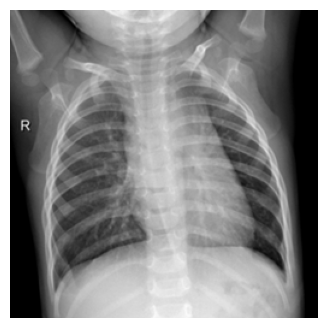

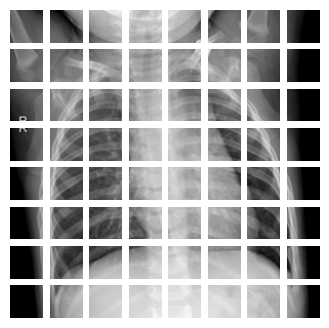

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [22]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [23]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [25]:
def run_experiment(model):
    # Optimizer
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],
    )

    # Train the model
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2
    )
    
    print("")
    
    # Plot training and validation accuracy and loss
    plt.figure(figsize=(12, 5))

    # Evaluate the model on the test set
    print("\nTesting::")
#     _, accuracy = model.evaluate(x_test, y_test)
#     print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    # Predict the values from the test dataset
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    #Accuracy
    print("Accuracy:: " + str(round(accuracy_score(y_true, y_pred_classes)*100, 2)) + "%")
    print("")
    
    class_indices = train_generator.class_indices
    class_names = list(class_indices.keys())
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return history

Epoch 1/100
27/27 [==============================] - 139s 884ms/step - loss: 4.6248 - accuracy: 0.5279 - val_loss: 0.7809 - val_accuracy: 0.6659
Epoch 2/100
27/27 [==============================] - 19s 690ms/step - loss: 0.7499 - accuracy: 0.6907 - val_loss: 0.5741 - val_accuracy: 0.7633
Epoch 3/100
27/27 [==============================] - 19s 690ms/step - loss: 0.6343 - accuracy: 0.7414 - val_loss: 0.4972 - val_accuracy: 0.8005
Epoch 4/100
27/27 [==============================] - 19s 692ms/step - loss: 0.5661 - accuracy: 0.7693 - val_loss: 0.4816 - val_accuracy: 0.8109
Epoch 5/100
27/27 [==============================] - 19s 691ms/step - loss: 0.5001 - accuracy: 0.7995 - val_loss: 0.4922 - val_accuracy: 0.7970
Epoch 6/100
27/27 [==============================] - 19s 689ms/step - loss: 0.5061 - accuracy: 0.7908 - val_loss: 0.4521 - val_accuracy: 0.8213
Epoch 7/100
27/27 [==============================] - 19s 690ms/step - loss: 0.4689 - accuracy: 0.8021 - val_loss: 0.4320 - val_accuracy

<Figure size 1200x500 with 0 Axes>

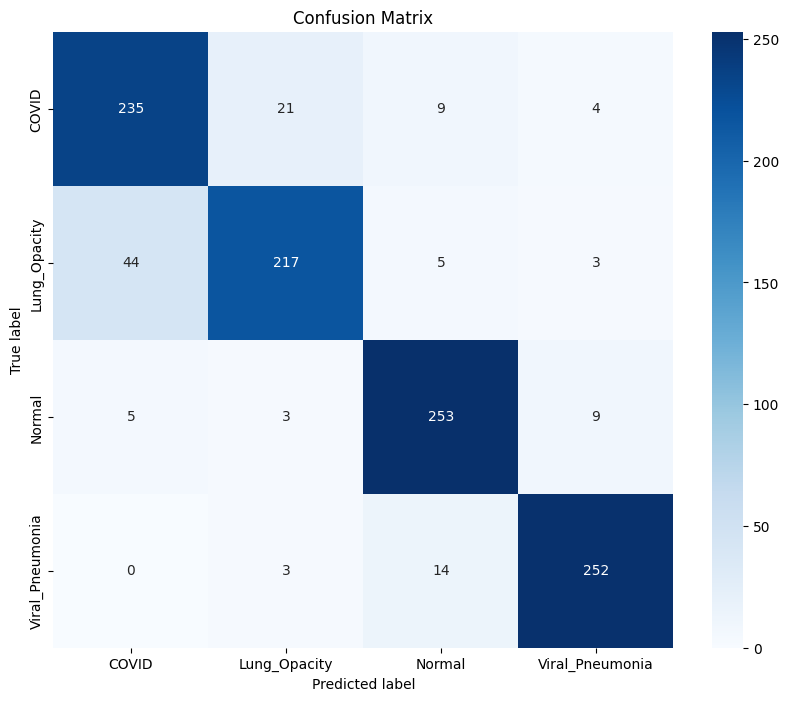

In [26]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

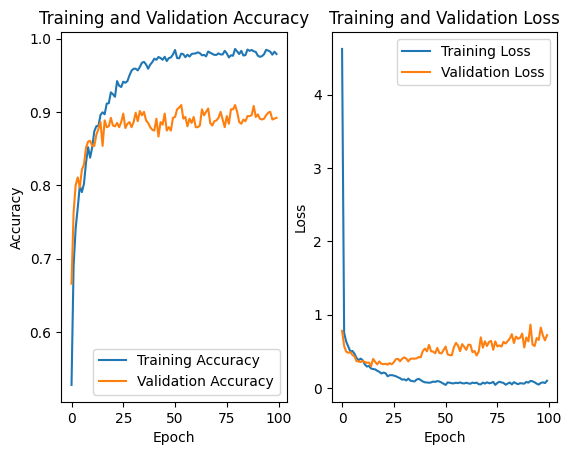

In [27]:
# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()